In [1]:
import time
import torch
import matplotlib.pyplot as plt
from torch_fps import farthest_point_sampling
from pytorch3d.ops import sample_farthest_points

In [2]:
# Time raw FPS sampling using torchfps and torch3d
def time_torchfps(seq_len, num_samples, point_dim=4096, device='cpu', dtype=torch.float32):
    points = torch.rand(2, seq_len, point_dim, dtype=dtype, device=device)
    mask = torch.ones(2, seq_len, dtype=torch.bool, device=device)
    start_time = time.time()
    _ = farthest_point_sampling(points, mask, num_samples)
    return time.time() - start_time

def time_torch3d(seq_len, num_samples, point_dim=4096, device='cpu', dtype=torch.float32):
    points = torch.rand(2, seq_len, point_dim, dtype=dtype, device=device)
    lengths = torch.full((2,), seq_len, dtype=torch.int64, device=device)
    start_time = time.time()
    _ = sample_farthest_points(points, lengths=lengths, K=num_samples)
    return time.time() - start_time

sequence_lengths = [400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000]
num_samples = 256

def run_timing_for_dtype(dtype, device='cpu'):
    torchfps_times = []
    torch3d_times = []
    for seq_len in sequence_lengths:
        elapsed_time = time_torchfps(seq_len, num_samples, device=device, dtype=dtype)
        torchfps_times.append(elapsed_time)
        print(f"torchfps {dtype} for seq_len={seq_len}: {elapsed_time:.4f} seconds")
    
    for seq_len in sequence_lengths:
        elapsed_time = time_torch3d(seq_len, num_samples, device=device, dtype=dtype)
        torch3d_times.append(elapsed_time)
        print(f"torch3d {dtype} for seq_len={seq_len}: {elapsed_time:.4f} seconds")
    
    return torchfps_times, torch3d_times

# Run timing for fp32 on CPU
torchfps_fp32_times, torch3d_fp32_times = run_timing_for_dtype(torch.float32, device='cpu')

# Run timing for fp16 on CPU
torchfps_fp16_times, torch3d_fp16_times = run_timing_for_dtype(torch.float16, device='cpu')

# Run timing for fp32/fp16 on GPU (if available)
torchfps_fp32_gpu_times = []
torch3d_fp32_gpu_times = []
torchfps_fp16_gpu_times = []
torch3d_fp16_gpu_times = []
if torch.cuda.is_available():
    device = torch.device('cuda:1' if torch.cuda.device_count() > 1 else 'cuda:0')
    torchfps_fp32_gpu_times, torch3d_fp32_gpu_times = run_timing_for_dtype(torch.float32, device=device)
    torchfps_fp16_gpu_times, torch3d_fp16_gpu_times = run_timing_for_dtype(torch.float16, device=device)
else:
    print("CUDA not available; skipping GPU timings.")

torchfps torch.float32 for seq_len=400: 0.5408 seconds
torchfps torch.float32 for seq_len=800: 1.0171 seconds
torchfps torch.float32 for seq_len=800: 1.0171 seconds
torchfps torch.float32 for seq_len=1200: 1.5238 seconds
torchfps torch.float32 for seq_len=1200: 1.5238 seconds
torchfps torch.float32 for seq_len=1600: 2.0362 seconds
torchfps torch.float32 for seq_len=1600: 2.0362 seconds
torchfps torch.float32 for seq_len=2000: 2.5438 seconds
torchfps torch.float32 for seq_len=2000: 2.5438 seconds
torchfps torch.float32 for seq_len=2400: 3.0622 seconds
torchfps torch.float32 for seq_len=2400: 3.0622 seconds
torchfps torch.float32 for seq_len=2800: 3.5776 seconds
torchfps torch.float32 for seq_len=2800: 3.5776 seconds
torchfps torch.float32 for seq_len=3200: 4.0839 seconds
torchfps torch.float32 for seq_len=3200: 4.0839 seconds
torchfps torch.float32 for seq_len=3600: 4.6128 seconds
torchfps torch.float32 for seq_len=3600: 4.6128 seconds
torchfps torch.float32 for seq_len=4000: 5.1133 sec

KeyboardInterrupt: 

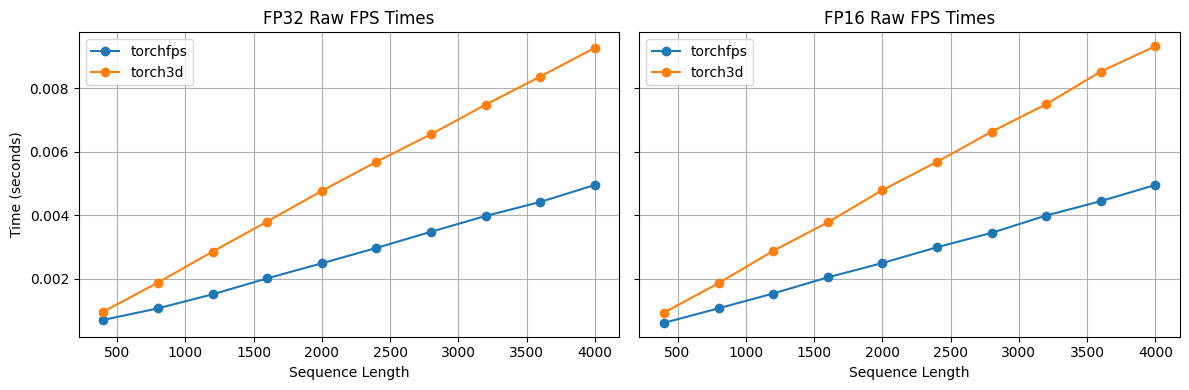

In [ ]:
# Graph the results
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# FP32
axes[0].plot(sequence_lengths, torchfps_fp32_times, label='torchfps', marker='o')
axes[0].plot(sequence_lengths, torch3d_fp32_times, label='torch3d', marker='o')
if torchfps_fp32_gpu_times:
    axes[0].plot(sequence_lengths, torchfps_fp32_gpu_times, label='torchfps GPU', marker='o')
if torch3d_fp32_gpu_times:
    axes[0].plot(sequence_lengths, torch3d_fp32_gpu_times, label='torch3d GPU', marker='o')
axes[0].set_title('FP32 Raw FPS Times')
axes[0].set_xlabel('Sequence Length')
axes[0].set_ylabel('Time (seconds)')
axes[0].grid(True)
axes[0].legend()

# FP16
axes[1].plot(sequence_lengths, torchfps_fp16_times, label='torchfps', marker='o')
axes[1].plot(sequence_lengths, torch3d_fp16_times, label='torch3d', marker='o')
if torchfps_fp16_gpu_times:
    axes[1].plot(sequence_lengths, torchfps_fp16_gpu_times, label='torchfps GPU', marker='o')
if torch3d_fp16_gpu_times:
    axes[1].plot(sequence_lengths, torch3d_fp16_gpu_times, label='torch3d GPU', marker='o')
axes[1].set_title('FP16 Raw FPS Times')
axes[1].set_xlabel('Sequence Length')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()